# The effect of over-sampling and under-sampling on model calibration

This note book examines the effect of under-sampling or over-sampling (including SMOTE) to balance training examples for imbalanced data, and shows alternative methods of recalibrating the model.

Note: a well-calibrated model is especially important when model prediction probabilities are read as risks (e.g. risk of emergency hopsital admission for any given patient).

## Observations

Using under-sampling or over-sampling to balance classes in training and test sets improved the recall of the model, at the expense of the precision of the model. Use of under-sampling or over-sampling led to an overestimation of the frequency of the minority class, and led to significant perturbation of the model calibration.

Recalibration of the model could restore calibration accuracy (at the loss of improved recall). The best calibration type was beta-calibration (https://pypi.org/project/betacal/).

## Load packages

In [1]:
# Install beta calibration package if not installed

try:
    import betacal
except:
    !pip install betacal

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from betacal import BetaCalibration

from sklearn.calibration import CalibrationDisplay
from sklearn.datasets import make_classification
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from sklearn.model_selection import train_test_split

## Generate data set

We will generate a set of data where 90% of examples are the negative class, and 10% the positive class.

In [3]:
X, y = make_classification(n_samples=20000, n_features=2, n_redundant=0,
        n_clusters_per_class=1, weights=[0.90, 0.10], class_sep=0.75, flip_y=0,
        hypercube=True, random_state=42)

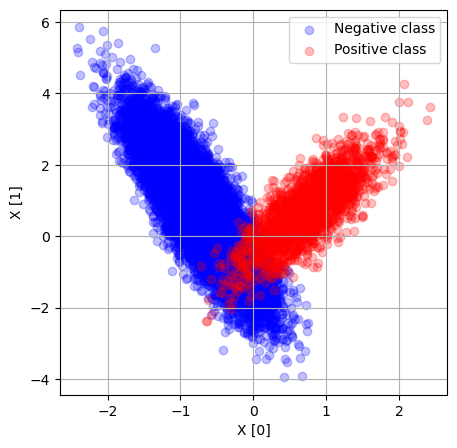

In [4]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot() 
mask = y == 0
ax.scatter (X[mask, 0], X[mask, 1], c='b', alpha=0.25, label='Negative class')
mask = y == 1
ax.scatter (X[mask, 0], X[mask, 1], c='r', alpha=0.25, label='Positive class')
ax.legend()
ax.set_xlabel('X [0]')
ax.set_ylabel('X [1]')
ax.grid()
plt.show()

### Split into training, test and calibration check sets

In [5]:
# Split full data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y)

# Split test into test and calibration check 
X_cal, X_test, y_cal, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

# Expand training set with SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

## Fit model to original data and oversampled or undersampled data

Note what happens to ROC AUC, recall (what proportion of actual positives was identified correctly?), precision (what proportion of positive identifications was actually correct?), and predicted positive rate (the real data has a positive rate of 0.10).

### Fit model to original data balance

In [6]:
model = LogisticRegression()
model.fit(X_train, y_train)

# Get acuracy scores
auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
print (f'ROC AUC: {auc:0.3f}')

recall = metrics.recall_score(y_test, model.predict(X_test))
print (f'Recall: {recall:0.3f}')

precision = metrics.precision_score(y_test, model.predict(X_test))
print (f'Precision: {precision:0.3f}')

predicted_positive_rate = model.predict_proba(X_test)[:,1].mean()
print (f'Predicted positive rate: {predicted_positive_rate:0.3f}')

ROC AUC: 0.989
Recall: 0.866
Precision: 0.982
Predicted positive rate: 0.100


### Fit model to randomly oversampled majority data

In [7]:
oversampler = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = oversampler.fit_resample(X_train, y_train)

model_oversampled = LogisticRegression()
model_oversampled.fit(X_oversampled,y_oversampled)

# Get acuracy scores
auc = metrics.roc_auc_score(y_test, model_oversampled.predict_proba(X_test)[:,1])
print (f'ROC AUC: {auc:0.3f}')

recall = metrics.recall_score(y_test, model_oversampled.predict(X_test))
print (f'Recall: {recall:0.3f}')

precision = metrics.precision_score(y_test, model_oversampled.predict(X_test))
print (f'Precision: {precision:0.3f}')

predicted_positive_rate = model_oversampled.predict_proba(X_test)[:,1].mean()
print (f'Predicted positive rate: {predicted_positive_rate:0.3f}')

ROC AUC: 0.991
Recall: 0.942
Precision: 0.725
Predicted positive rate: 0.158


### Fit model to SMOTE over-sampled data

In [8]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

model_smote = LogisticRegression()
model_smote.fit(X_smote, y_smote)

# Get acuracy scores
auc = metrics.roc_auc_score(y_test, model_smote.predict_proba(X_test)[:,1])
print (f'ROC AUC: {auc:0.3f}')

recall = metrics.recall_score(y_test, model_smote.predict(X_test))
print (f'Recall: {recall:0.3f}')

precision = metrics.precision_score(y_test, model_smote.predict(X_test))
print (f'Precision: {precision:0.3f}')

predicted_positive_rate = model_smote.predict_proba(X_test)[:,1].mean()
print (f'Predicted positive rate: {predicted_positive_rate:0.3f}')

ROC AUC: 0.991
Recall: 0.942
Precision: 0.722
Predicted positive rate: 0.158


### Fit model to random undersampled majority data

In [9]:
undersampler = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)

model_undersampled = LogisticRegression()
model_undersampled.fit(X_undersampled,y_undersampled)

# Get acuracy scores
auc = metrics.roc_auc_score(y_test, model_undersampled.predict_proba(X_test)[:,1])
print (f'ROC AUC: {auc:0.3f}')

recall = metrics.recall_score(y_test, model_undersampled.predict(X_test))
print (f'Recall: {recall:0.3f}')

precision = metrics.precision_score(y_test, model_undersampled.predict(X_test))
print (f'Precision: {precision:0.3f}')

predicted_positive_rate = model_undersampled.predict_proba(X_test)[:,1].mean()
print (f'Predicted positive rate: {predicted_positive_rate:0.3f}')

ROC AUC: 0.991
Recall: 0.942
Precision: 0.745
Predicted positive rate: 0.163


## Show calibration curves for models trained on data sets

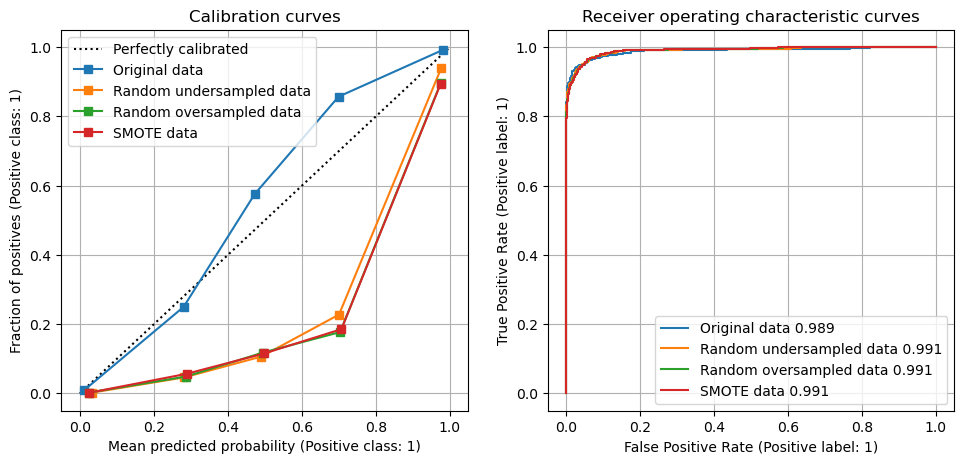

In [10]:
fig = plt.figure(figsize=(10,5))

# Calibration
ax1 = fig.add_subplot(121)
disp1 = CalibrationDisplay.from_estimator(
    model, X_test, y_test, ax=ax1, n_bins=5, label='Original data')
disp2 = CalibrationDisplay.from_estimator(
    model_undersampled, X_test, y_test, ax=ax1, n_bins=5, label='Random undersampled data')
disp3 = CalibrationDisplay.from_estimator(
    model_oversampled, X_test, y_test, ax=ax1, n_bins=5, label='Random oversampled data')
disp4 = CalibrationDisplay.from_estimator(
    model_smote, X_test, y_test, ax=ax1, n_bins=5, label='SMOTE data')
ax1.legend(loc='upper left')
ax1.set_title('Calibration curves')
ax1.grid()

# ROC
ax2 = fig.add_subplot(122)

auc = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
disp1 = metrics.RocCurveDisplay.from_estimator(
    model, X_test, y_test, ax=ax2, label=f'Original data {auc:0.3f}')

auc = metrics.roc_auc_score(y_test, model_undersampled.predict_proba(X_test)[:,1])
disp2 = metrics.RocCurveDisplay.from_estimator(
    model_undersampled, X_test, y_test, ax=ax2, label=f'Random undersampled data {auc:0.3f}')

auc = metrics.roc_auc_score(y_test, model_oversampled.predict_proba(X_test)[:,1])
disp3 = metrics.RocCurveDisplay.from_estimator(
    model_oversampled, X_test, y_test, ax=ax2, label=f'Random oversampled data {auc:0.3f}')

auc = metrics.roc_auc_score(y_test, model_smote.predict_proba(X_test)[:,1])
disp4 = metrics.RocCurveDisplay.from_estimator(
    model_smote, X_test, y_test, ax=ax2, label=f'SMOTE data {auc:0.3f}')

ax2.set_title('Receiver operating characteristic curves')
ax2.grid()

plt.tight_layout(pad=2)
plt.show()

## Calibrate model results with three methods

We will calibrate the data with three methods:

* Logistic regression (Platt sclaing)
* Isotonic regresssion
* Beta calibratio (betacal)

Here will will demonstrate these methods with SMOTE oversampling.

We will fit the calibrator to the test data, and test against the calibration check data.

### Model fitted to raw SMOTE data without calibration

In [11]:
# Get calibration check set predictions
cal_proba = model_smote.predict_proba(X_cal)[:,1]
cal_proba = cal_proba.reshape(-1, 1)

# Get acuracy scores
auc = metrics.roc_auc_score(y_cal, cal_proba)
print (f'ROC AUC: {auc:0.3f}')

recall = metrics.recall_score(y_cal, cal_proba >= 0.5)
print (f'Recall: {recall:0.3f}')

precision = metrics.precision_score(y_cal, cal_proba >= 0.5)
print (f'Precision: {precision:0.3f}')

predicted_positive_rate = np.mean(cal_proba >= 0.5)
print (f'Predicted positive rate: {predicted_positive_rate:0.3f}')

ROC AUC: 0.993
Recall: 0.948
Precision: 0.714
Predicted positive rate: 0.133


### SMOTE fit calibrated with logistic regression

In [12]:
# Get test set predicitons
smote_test_pred = model_smote.predict_proba(X_test)[:,1]
smote_test_pred = smote_test_pred.reshape(-1, 1)

# Fit logistic calibrator
lr = LogisticRegression(C=9999)
lr.fit(smote_test_pred, y_test)

# Get calibrated probablilities
lr_calibrated = lr.predict_proba(cal_proba)

# Get acuracy scores
auc = metrics.roc_auc_score(y_cal, lr_calibrated[:,1])
print (f'ROC AUC: {auc:0.3f}')

recall = metrics.recall_score(y_cal, lr_calibrated[:,1] >= 0.5)
print (f'Recall: {recall:0.3f}')

precision = metrics.precision_score(y_cal, lr_calibrated[:,1] >= 0.5)
print (f'Precision: {precision:0.3f}')

predicted_positive_rate = np.mean(lr_calibrated[:,1] >= 0.5)
print (f'Predicted positive rate: {predicted_positive_rate:0.3f}')

ROC AUC: 0.993
Recall: 0.928
Precision: 0.874
Predicted positive rate: 0.106


### SMOTE fit calibrated with isotonic regression

In [13]:
# Fit isotonic calibrator
iso = IsotonicRegression()
iso.fit(smote_test_pred, y_test)

# Get calibrated probablilities
iso_calibrated = iso.predict(cal_proba)

# Get acuracy scores
auc = metrics.roc_auc_score(y_cal, iso_calibrated)
print (f'ROC AUC: {auc:0.3f}')

recall = metrics.recall_score(y_cal, iso_calibrated >= 0.5)
print (f'Recall: {recall:0.3f}')

precision = metrics.precision_score(y_cal, iso_calibrated >= 0.5)
print (f'Precision: {precision:0.3f}')

predicted_positive_rate = np.mean(iso_calibrated >= 0.5)
print (f'Predicted positive rate: {predicted_positive_rate:0.3f}')

ROC AUC: 0.992
Recall: 0.862
Precision: 0.956
Predicted positive rate: 0.090


### SMOTE fit calibrated with beta regression

In [14]:
# Fit isotonic calibrator
beta = BetaCalibration(parameters="abm")
beta.fit(smote_test_pred, y_test)

# Get calibrated probablilities
beta_calibrated = beta.predict(cal_proba)

# Get acuracy scores
auc = metrics.roc_auc_score(y_cal, beta_calibrated)
print (f'ROC AUC: {auc:0.3f}')

recall = metrics.recall_score(y_cal, beta_calibrated >= 0.5)
print (f'Recall: {recall:0.3f}')

precision = metrics.precision_score(y_cal, beta_calibrated >= 0.5)
print (f'Precision: {precision:0.3f}')

predicted_positive_rate = np.mean(beta_calibrated >= 0.5)
print (f'Predicted positive rate: {predicted_positive_rate:0.3f}')

ROC AUC: 0.993
Recall: 0.882
Precision: 0.946
Predicted positive rate: 0.093


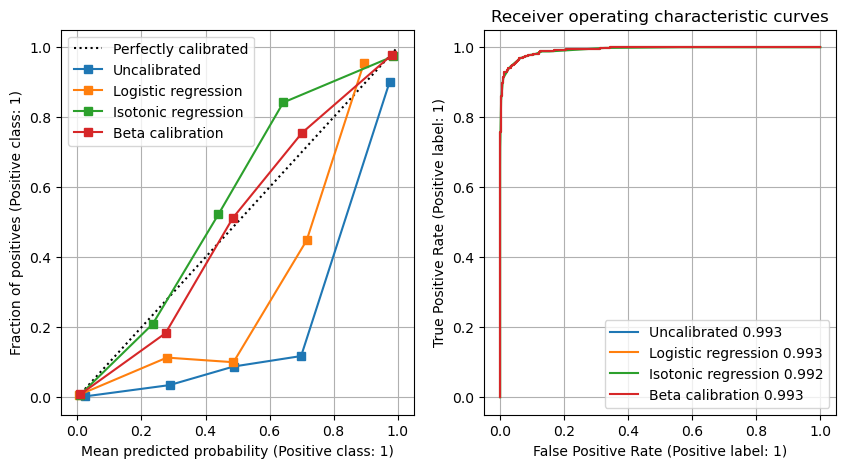

In [15]:
fig = plt.figure(figsize=(10,5))

# Calibration

ax1 = fig.add_subplot(121)

disp1 = CalibrationDisplay.from_predictions(y_cal, cal_proba,
     ax=ax1, n_bins=5, label='Uncalibrated')

disp2 = CalibrationDisplay.from_predictions(y_cal, lr_calibrated[:, 1],
     ax=ax1, n_bins=5, label='Logistic regression')

disp3 = CalibrationDisplay.from_predictions(y_cal, iso_calibrated,
     ax=ax1, n_bins=5, label='Isotonic regression')

disp4 = CalibrationDisplay.from_predictions(y_cal, beta_calibrated,
     ax=ax1, n_bins=5, label='Beta calibration')

ax1.grid()
ax1.legend(loc='upper left')


# ROC
ax2 = fig.add_subplot(122)

auc = metrics.roc_auc_score(y_cal, cal_proba)
disp1 = metrics.RocCurveDisplay.from_predictions(
    y_cal, cal_proba, ax=ax2, label=f'Uncalibrated {auc:0.3f}')

auc = metrics.roc_auc_score(y_cal, lr_calibrated[:,1])
disp2 = metrics.RocCurveDisplay.from_predictions(y_cal, lr_calibrated[:, 1], 
    ax=ax2, label=f'Logistic regression {auc:0.3f}')

auc = metrics.roc_auc_score(y_cal, iso_calibrated)
disp3 = metrics.RocCurveDisplay.from_predictions(y_cal, iso_calibrated,
    ax=ax2, label=f'Isotonic regression {auc:0.3f}')

auc = metrics.roc_auc_score(y_cal, beta_calibrated)
disp4 = metrics.RocCurveDisplay.from_predictions(y_cal, beta_calibrated,
    ax=ax2, label=f'Beta calibration {auc:0.3f}')

ax2.set_title('Receiver operating characteristic curves')
ax2.grid()

plt.show()

## Observations

Using under-sampling or over-sampling to balance classes in training and test sets improved the recall of the model, at the expense of the precision of the model. Use of under-sampling or over-sampling led to an overestimation of the frequency of the minority class, and led to significant perturbation of the model calibration.

Recalibration of the model could restore calibration accuracy (at the loss of improved recall). The best calibration type was beta-calibration (https://pypi.org/project/betacal/).